In [1]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import numpy as np
import geopandas
import pandas
from shapely.geometry import box
from rasterio.features import shapes
from shapely.geometry import shape, Point, MultiPolygon, Polygon
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from geopy.geocoders import Nominatim
from datetime import datetime, timedelta
import requests
import cenpy
import statsmodels.api as sm
from scipy.stats import boxcox_normmax, boxcox

import sys
import urllib.request
import json
import math
import ssl

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# fips and census blocks

In [2]:
#FIPS:

fips = pandas.read_csv("fips.csv")

<Axes: >

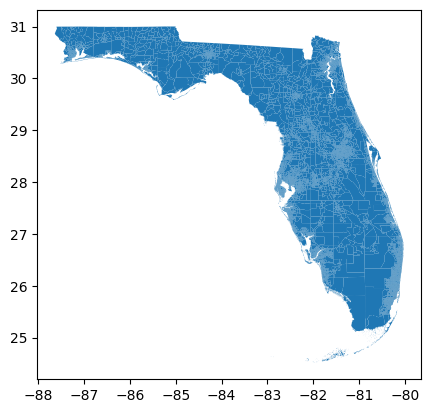

In [24]:
fl = geopandas.read_file("shp/USA Census Block Group Boundaries selection.shp")
fl.plot()

# NOAA qpe

In [4]:
#load noaa
with rasterio.open("noaa_2019_precip/nws_precip_ytd_20200101_conus.tif") as dataset:
    bord = dataset.read()

    a = [x for x in dataset.sample([(871,696)])]

    transform, width, height = rasterio.warp.calculate_default_transform(dataset.crs, fl.crs, dataset.width, dataset.height, *dataset.bounds)
    kwargs = dataset.meta.copy()
    kwargs.update({'crs':fl.crs, 'transform':transform, 'width':width, 'height':height})

    dst_shape = (4,881,1121)
    dest = np.zeros(dst_shape)

    with rasterio.open('reprojected_noaa_precip_2019.tif', 'w', **kwargs) as output:
        for i in range(1, dataset.count + 1):
            rasterio.warp.reproject(source = rasterio.band(dataset, i), destination= rasterio.band(output,i), src_transform=dataset.transform, src_crs=dataset.crs, dst_transform=transform, dst_crs=fl.crs, resampling = rasterio.warp.Resampling.nearest)


In [5]:
#reproject noaa to be usable
reprojected_noaa = []

with rasterio.open("reprojected_noaa_precip_2019.tif") as dataset:
    reprojected_noaa = dataset.read()

    crib = reprojected_noaa[0][0][0]
    print(crib)

    maxx = np.max(reprojected_noaa)
    for band in range(len(reprojected_noaa)):
        for row in range(len(reprojected_noaa[band])):
            for col in range(len(reprojected_noaa[band][row])):
                if reprojected_noaa[band][row][col] < 0:
                    reprojected_noaa[band][row][col] = 0
                else:
                    reprojected_noaa[band][row][col] = reprojected_noaa[band][row][col]/maxx

    print(np.max(reprojected_noaa), np.min(reprojected_noaa))

-3.4028235e+38
1.0 0.0


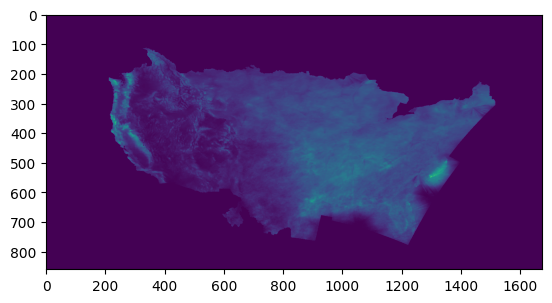

<Axes: >

In [6]:
show(reprojected_noaa[0])

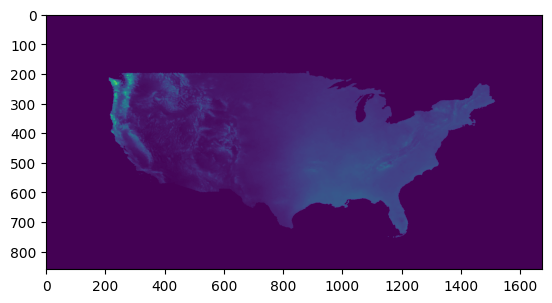

<Axes: >

In [7]:
show(reprojected_noaa[1])

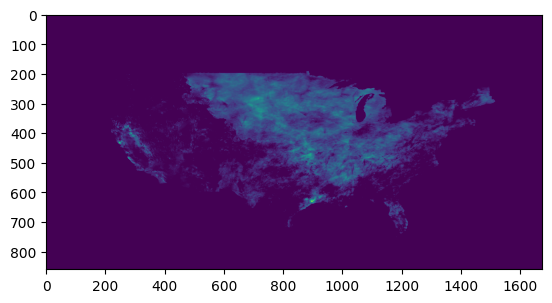

<Axes: >

In [8]:
show(reprojected_noaa[2])

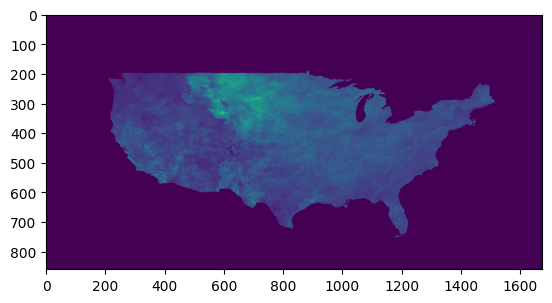

<Axes: >

In [9]:
show(reprojected_noaa[3])

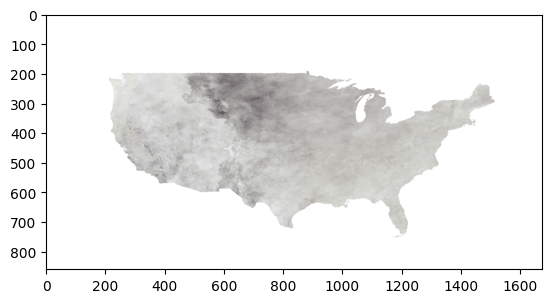

<Axes: >

In [10]:
show(reprojected_noaa)

# 2019 Claims

In [11]:
#load claims
claims_2019 = pandas.read_csv("2019acsclaims.csv")

new_claims_2019 = []

#number of data points used
maxx = 10000
for claim in claims_2019.iterrows():

    dic = claim[1].to_dict()
    if math.isnan(dic["ACS2019_Census_Block_Group"]) or dic["Net Building Payment Amount"] < 0 or dic["Net Contents Payment Amount"] < 0:
        continue

    if dic["Occupancy Type"] != 1 and dic["Occupancy Type"] != 11:
        continue

    maxx -= 1
    if maxx < 0:
        break

    new_claims_2019.append(claim[1].to_dict())
        


/var/folders/2d/qq10trf944qf_xk31fs7s4w80000gn/T/ipykernel_78692/354646500.py:1: DtypeWarning: Columns (42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  claims_2019 = pandas.read_csv("2019acsclaims.csv")


In [12]:
# add geometry to claims for geospacial join
counties = [pandas.DataFrame(fl)[pandas.DataFrame(fl)["FIPS"] == str(int(claim["ACS2019_Census_Block_Group"]))]["geometry"] for claim in new_claims_2019]

for i in range(len(new_claims_2019)):
    new_claims_2019[i]["geometry"] = counties[i]


### merging noaa and claims

In [23]:
#geospacial join
with rasterio.open("reprojected_noaa_precip_2019.tif") as dataset:

    val = dataset.read(1)[0][0]

    for i in range(len(new_claims_2019)):

        try:
            val = mask(dataset, new_claims_2019[i]["geometry"], crop = False)

            exper = np.any(val[0] != crib)

            sum = 0
            for iter in val[0]:
                for iterr in iter:
                    for iterrr in iterr:
                        if iterrr != crib:
                            sum += iterrr/val

            
            
            new_claims_2019[i]["raster value"] = sum/list(new_claims_2019[i]["geometry"])[0].area

        except:
            new_claims_2019[i]["raster value"] = -1



## census

In [3]:
#use to create census_data for the first time, once the dataset is created, save it locally using below code and load from below below code

def pullCensus(query):
    try:
        return cenpy.products.ACS(2019).from_state("Florida", variables=[query])
    except:
        print("failed at",query)
        return pullCensus(query)

census_data = {}
census_queries = ["B19013_001E", "B19101A_001E", "B06009_001E","B06009_004E", "B07001_002E","B07001_003E","B07001_013E","B07001_014E","B07001_015E","B07001_016E","B05003G_013E","B03002_012E","B02001_002E","B02001_003E","B02001_005E","B02001_006E","B21001_002E"]
census_keys = ["income","median","total","with undergrad degree","age 1-4","age 5-17","age 60-64","age 65-69","age 70-74","age 75+","#women","# latino","# white","# black","# asian","# islander","# vets"]

for i in range(len(census_queries)):
    census_data[census_keys[i]] = pullCensus(census_queries[i])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)


failed at B06009_001E
failed at B06009_001E


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)


failed at B07001_002E


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)


failed at B07001_003E
failed at B07001_003E


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)


failed at B07001_013E


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)


failed at B07001_014E


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)


failed at B07001_015E
failed at B07001_015E
failed at B07001_015E


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)


failed at B05003G_013E


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)


failed at B03002_012E


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)


failed at B02001_002E
failed at B02001_002E


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)


failed at B02001_003E


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)


failed at B02001_006E


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cenpy/products.py:767: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return self._from_name(state, variables, level, "States", **kwargs)


In [14]:
#save
for key in census_data.keys():
    tempdf = pandas.DataFrame(census_data[key])
    tempdf.to_csv("/census_csvs/" + key + "_cen2019.csv")


In [233]:
#load
census_data = {}
for key in census_keys:
    tempdf = pandas.read_csv("/census_csvs/" + key + "_cen2019.csv")
    census_data[key] = tempdf


In [234]:
#merge census with claims
for i in range(len(census_keys)):
    census_var = census_data[census_keys[i]]
    counties = [census_var[census_var["GEOID"] == int(claim["ACS2019_Census_Block_Group"])//10][census_queries[i]] for claim in new_claims_2019]
    for j in range(len(new_claims_2019)):
        new_claims_2019[j][census_keys[i]] = counties[j].iloc[0]

### correlation plots

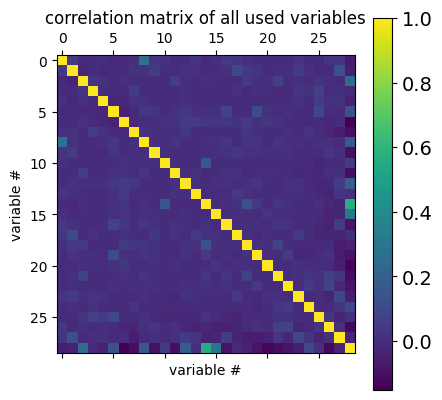

In [239]:
reduced_data = [{
    claim["Total Building Insurance Coverage"], # 0
    claim["Total Contents Insurance Coverage"], # 1
    claim["Building Damage Amount"], # 2
    claim["Contents Damage Amount"], # 3
    claim["Building Property Value"], # 4
    claim["Contents Property Value"], # 5
    claim["Net Building Payment Amount"], # 6
    claim["Net Contents Payment Amount"], # 7
    claim["Number Of Floors In The Insured Building"], # 8
    claim["Building Replacement Cost"], # 9
    claim["Contents Replacement Cost"], # 10
    claim["income"], # 11
    claim["median"], # 12
    claim["raster value"], # 13
    claim["total"], # 14
    claim["with undergrad degree"], # 15
    claim["age 1-4"], # 16
    claim["age 5-17"], # 17
    claim["age 60-64"], # 18
    claim["age 65-69"], # 19
    claim["age 70-74"], # 20
    claim["age 75+"], # 21
    claim["#women"], # 22
    claim["# latino"], # 23
    claim["# white"], # 24
    claim["# black"], # 25
    claim["# asian"], # 26
    claim["# islander"], # 27
    claim["# vets"], # 28

    } for claim in new_claims_2019]

reduced_data = pandas.DataFrame(reduced_data)
plt.matshow(reduced_data.corr())

plt.xlabel('variable #')
plt.ylabel('variable #')
plt.title('correlation matrix of all used variables')

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)


Text(0.5, 1.0, 'cov matrix of data')

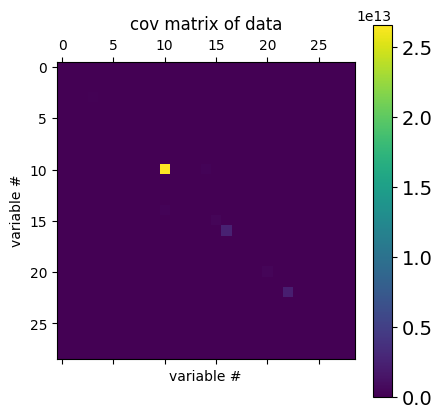

In [240]:
plt.matshow(reduced_data.cov())
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.xlabel('variable #')
plt.ylabel('variable #')
plt.title('cov matrix of data')

### outliers

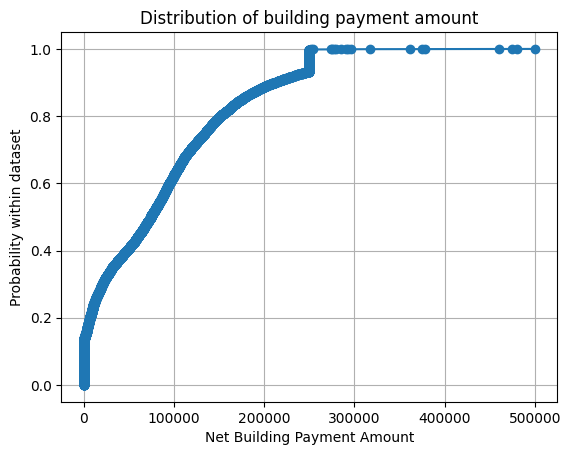

In [237]:
y = [claim["Net Building Payment Amount"] for claim in new_claims_2019]
sorted_y = np.sort(y)
probs = np.arange(1, len(sorted_y) + 1) / len(sorted_y)
plt.plot(sorted_y, probs, marker = 'o')

plt.xlabel('Net Building Payment Amount')
plt.ylabel('Probability within dataset')
plt.title('Distribution of building payment amount')
plt.grid(True)


In [238]:
#filter outliers
data_save = new_claims_2019.copy()
copy_2019 = []
for claim in new_claims_2019:
    if claim["Net Building Payment Amount"] <= 250000:
        copy_2019.append(claim)

new_claims_2019 = copy_2019
print(len(new_claims_2019))

9982


In [292]:
#all variables
x = [[
    claim["Building Damage Amount"],
    claim["Contents Damage Amount"],
    claim["Building Property Value"],
    claim["Contents Property Value"],

    (1 if claim["Cause of Damage Code"] == 1.0 else 0),
    (1 if claim["Cause of Damage Code"] == 2.0 else 0),
    (1 if claim["Cause of Damage Code"] == 3.0 else 0),
    (1 if claim["Cause of Damage Code"] == 4.0 else 0),
    (1 if claim["Cause of Damage Code"] == 7.0 else 0),
    (1 if claim["Cause of Damage Code"] == 8.0 else 0),

    (1 if claim["Number Of Floors In The Insured Building"] == 1.0 else 0),
    (1 if claim["Number Of Floors In The Insured Building"] == 2.0 else 0),
    (1 if claim["Number Of Floors In The Insured Building"] == 3.0 else 0),
    (1 if claim["Number Of Floors In The Insured Building"] > 3.0 else 0),

    claim["Building Replacement Cost"],
    claim["Contents Replacement Cost"],
    claim["income"],
    claim["median"],
    claim["raster value"],
    claim["total"],
    claim["with undergrad degree"],
    claim["age 1-4"],
    claim["age 5-17"],
    claim["age 60-64"],
    claim["age 65-69"],
    claim["age 70-74"],
    claim["age 75+"],
    claim["#women"],
    claim["# latino"],
    claim["# white"],
    claim["# black"],
    claim["# asian"],
    claim["# islander"],
    claim["# vets"],
    ] for claim in new_claims_2019]

for i in range(len(x)):
    for j in range(len(x[i])):
        if math.isnan(x[i][j]):
            x[i][j] = -1

y = [claim["Net Building Payment Amount"] for claim in new_claims_2019]
x_names = ["Building Damage Amount", "Contents Damage Amount", "Building Property Value", "Contents Property Value","damage code 1","damage code 2", "damage code 3", "damage code 4", "damage code 7", "damage code 8","1 floor", "2 floors", "3 floors", "4+ floors", "building replacement cost", "contents replacement cost", "income","median","precip","total population", "undergrad degrees", "1-4","5-17","60-64","65-69","70-74","75+","women","latino","white","black","asian","islander","veteran"]

model = sm.OLS(y,x).fit()

print(model.summary(xname=x_names))


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.919
Model:                            OLS   Adj. R-squared (uncentered):              0.919
Method:                 Least Squares   F-statistic:                              3517.
Date:                Thu, 09 May 2024   Prob (F-statistic):                        0.00
Time:                        12:42:55   Log-Likelihood:                     -1.1795e+05
No. Observations:                9982   AIC:                                  2.360e+05
Df Residuals:                    9950   BIC:                                  2.362e+05
Df Model:                          32                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [296]:
#some variables
x = [[
    claim["Total Building Insurance Coverage"],
    claim["Total Contents Insurance Coverage"],
    (1 if claim["Cause of Damage Code"] == 1.0 else 0),
    (1 if claim["Cause of Damage Code"] == 2.0 else 0),
    (1 if claim["Cause of Damage Code"] == 3.0 else 0),
    (1 if claim["Cause of Damage Code"] == 4.0 else 0),
    (1 if claim["Cause of Damage Code"] == 0.0 else 0),

    (1 if claim["Number Of Floors In The Insured Building"] == 1.0 else 0),
    (1 if claim["Number Of Floors In The Insured Building"] == 2.0 else 0),
    (1 if claim["Number Of Floors In The Insured Building"] == 3.0 else 0),
    (1 if claim["Number Of Floors In The Insured Building"] > 3.0 else 0),

    claim["Building Replacement Cost"],
    claim["Contents Replacement Cost"],
    claim["raster value"], 

    claim["Building Property Value"]**.5,
    claim["Contents Property Value"]**.5,
    (math.log(claim["income"])) if claim["income"] > 0 else 0,
    (math.log(claim["median"])) if claim["median"] > 0 else 0,
    (math.log(claim["raster value"])) if claim["raster value"] > 0 else 0,

    claim['with undergrad degree'],
    claim["age 1-4"] + claim["age 5-17"],
    claim["age 60-64"] + claim["age 65-69"] + claim["age 70-74"] + claim["age 75+"],
    claim["#women"], #
    claim["# latino"] + claim["# black"],
    claim["# vets"] ** .33, 

    ] for claim in new_claims_2019]

for i in range(len(x)):
    for j in range(len(x[i])):
        if math.isnan(x[i][j]):
            x[i][j] = -1

y = [claim["Net Building Payment Amount"] for claim in new_claims_2019]
x_names = ["Total Building Insurance", "Total Contents Insurance", "tidal overflow [bool]", "stream/lake/river overflow [bool]", "alluvial overflow[bool]", "rainfall/snow accumulation[bool]", "other cause [bool]", "has 1 floor [bool]", "has 2 floors [bool]", "has 3 floors [bool]", "has >3 floors [bool]", "building replacement cost", "contents replacement cost", "perceptation", "sqrt building property value", "sqrt contents property value", "log average income", "log median property", "log percipitation", "#undergrad", "#children", "#elderly","#women","#minorities","#vets"]

model = sm.OLS(y,x).fit()

print(model.summary(xname= x_names))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.652
Model:                            OLS   Adj. R-squared (uncentered):              0.651
Method:                 Least Squares   F-statistic:                              746.2
Date:                Thu, 09 May 2024   Prob (F-statistic):                        0.00
Time:                        12:47:59   Log-Likelihood:                     -1.2521e+05
No. Observations:                9982   AIC:                                  2.505e+05
Df Residuals:                    9957   BIC:                                  2.506e+05
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------

### tukey

In [99]:
query = "# white"
test = [int(claim[query]) for claim in new_claims_2019 if (not math.isnan(claim[query]) and claim[query] >= 1)]
lam = boxcox_normmax(test)
transformed = boxcox(test, lmbda= lam)

print("lambda", lam)

lambda 0.22197142698243563


## Some Models 2019

In [255]:
def MAPE(y_real, pred): 
    temp_real = np.array(y_real.copy())
    temp_pred = np.array(pred.copy())
    return np.mean(np.abs(temp_real - temp_pred) / temp_real) * 100

In [297]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

training, labels = x,y
forest = RandomForestRegressor(max_depth=20, n_estimators=1000).fit(x,y)
prediction = forest.predict(training)
mse = mean_squared_error(prediction, labels)
print(mse)

697273584.3910353


In [257]:
prep_y = []
prep_pred = []

for i in range(len(y)):
    if y[i] < 1:
        continue
    prep_y.append(y[i])
    prep_pred.append(prediction[i])

print(MAPE(prep_y,prep_pred))

91.89012280489706


In [286]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

training, labels = x,y
poly = PolynomialFeatures(degree=2, include_bias=True)
polyx = poly.fit_transform(training)

linreg = LinearRegression().fit(polyx,labels)
prediction = linreg.predict(polyx)
mse = mean_squared_error(prediction, labels)
print(mse)

4136876934.012158


In [287]:
prep_y = []
prep_pred = []

for i in range(len(y)):
    if y[i] < 1:
        continue
    prep_y.append(y[i])
    prep_pred.append(prediction[i])

print(MAPE(prep_y,prep_pred))

229.66969491679072
